In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

def calculate_oxide_thickness(
    # Основные параметры процесса
    T,           # температура [°C]
    P,           # давление [атм]
    time,        # время [ч]
    orientation, # ориентация: '100', '110', '111'
    ambient,     # среда: 'dry' или 'wet'
    
    # Параметры легирования
    doping_type=None,  # 'p' или 'n'
    doping_conc=0,     # концентрация [см⁻³]
    N_ref=1e19,        # эталонная концентрация [см⁻³]
    
    # Начальные условия
    x0=0.002,          # начальная толщина [мкм]
    
    # Параметры модели для сухого кислорода
    B0_dry=7.72e2, Ea_B_dry=1.23,      # для B
    BA0_dry=6.23e6, Ea_BA_dry=2.00,    # для B/A
    exp_B_dry=1.0, exp_BA_dry=0.7,     # показатели степени для давления
    
    # Параметры модели для влажного кислорода  
    B0_wet=2.14e2, Ea_B_wet=0.71,      # для B
    BA0_wet=8.95e7, Ea_BA_wet=2.05,    # для B/A
    exp_B_wet=1.0, exp_BA_wet=0.5,     # показатели степени для давления
    
    # Коэффициенты ориентации
    K_100=1.0, K_110=1.45, K_111=1.68,
    
    # Коэффициенты легирования
    alpha_B=0.5, alpha_P=1.0
):
    """
    Расчёт толщины окисла по модели Дила-Гроува с параметризованными константами
    """
    
    # Константы
    k = 8.617e-5  # эВ/К
    
    # Температура в Кельвинах
    T_K = T + 273.15
    
    # Выбор параметров в зависимости от среды
    if ambient == 'dry':
        B0 = B0_dry
        Ea_B = Ea_B_dry
        BA0 = BA0_dry
        Ea_BA = Ea_BA_dry
        exp_B = exp_B_dry
        exp_BA = exp_BA_dry
    else:  # wet
        B0 = B0_wet
        Ea_B = Ea_B_wet
        BA0 = BA0_wet
        Ea_BA = Ea_BA_wet
        exp_B = exp_B_wet
        exp_BA = exp_BA_wet
    
    # Расчёт B с учётом температуры и давления
    B = B0 * np.exp(-Ea_B / (k * T_K)) * (P ** exp_B)
    
    # Расчёт B/A 
    orient_factors = {'100': K_100, '110': K_110, '111': K_111}
    BA = BA0 * np.exp(-Ea_BA / (k * T_K)) * (P ** exp_BA) * orient_factors[orientation]
    
    # Поправка на легирование
    if doping_type == 'p' and doping_conc > N_ref:
        B *= (1 + alpha_B * doping_conc / N_ref)
    elif doping_type == 'n' and doping_conc > N_ref:
        BA *= (1 + alpha_P * doping_conc / N_ref)
    
    # Параметр A
    A = B / BA
    
    # Поправка времени
    tau = (x0**2 + A * x0) / B
    
    # Решение уравнения Дила-Гроува
    x = (np.sqrt(A**2 + 4 * B * (time + tau)) - A) / 2
    
    return x, A, B, BA

# Пример использования с кастомными параметрами
thickness, A, B, BA = calculate_oxide_thickness(
    T=1000, P=1.0, time=2.0, 
    orientation='100', ambient='dry',
    doping_type='n', doping_conc=5e19,
    
    # Можно переопределить любые параметры модели:
    B0_dry=8.0e2,        # свой предекспоненциальный множитель
    Ea_B_dry=1.25,       # своя энергия активации
    K_111=1.70,          # свой коэффициент для ориентации (111)
    alpha_P=1.2          # свой коэффициент для фосфора
)

print( thickness)

def aaaaaaa(x): return True

0.12611690606740644


In [5]:
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from scipy import special

class DiffusionSimulator2D:
    """
    2D симулятор диффузии примесей и точечных дефектов в кремнии
    """
    
    def __init__(self, nx, ny, dx, dy):
        self.nx, self.ny = nx, ny
        self.dx, self.dy = dx, dy
        self.C_i = np.zeros((ny, nx))  # концентрация примеси
        self.C_I = np.zeros((ny, nx))  # концентрация междоузлий
        self.C_V = np.zeros((ny, nx))  # концентрация вакансий
        
    def set_initial_conditions(self, C_i0, C_I0, C_V0):
        """Установка начальных условий"""
        self.C_i = C_i0.copy()
        self.C_I = C_I0.copy()
        self.C_V = C_V0.copy()
    
    def compute_diffusion_coefficient(self, D_i_star, f_I, C_I_eq, C_V_eq):
        """Вычисление коэффициента диффузии с учетом точечных дефектов"""
        return D_i_star * (f_I * self.C_I/C_I_eq + (1 - f_I) * self.C_V/C_V_eq)
    
    def solve_defect_equations(self, dt, D_I, D_V, K_R, C_I_eq, C_V_eq, g_I=0):
        """
        Решение уравнений для точечных дефектов методом конечных разностей
        """
        # Преобразуем g_I в массив правильной размерности если это скаляр
        if np.isscalar(g_I):
            g_I_array = np.full((self.ny, self.nx), g_I)
        else:
            g_I_array = g_I
            
        # Вычисляем члены рекомбинации
        recombination = K_R * (self.C_I * self.C_V - C_I_eq * C_V_eq)
        
        # Неявная схема для междоузлий
        A_I = self.build_matrix(D_I, dt, self.dx, self.dy)
        b_I = self.C_I.ravel() + dt * (g_I_array.ravel() - recombination.ravel())
        self.C_I = spsolve(A_I, b_I).reshape(self.ny, self.nx)
        
        # Неявная схема для вакансий
        A_V = self.build_matrix(D_V, dt, self.dx, self.dy)
        b_V = self.C_V.ravel() + dt * (-recombination.ravel())
        self.C_V = spsolve(A_V, b_V).reshape(self.ny, self.nx)
    
    def solve_impurity_diffusion(self, dt, D_i, z, T, epsilon):
        """
        Решение уравнения диффузии примеси с учетом электрического поля
        """
        # Если D_i - скаляр, преобразуем в массив
        if np.isscalar(D_i):
            D_i_array = np.full((self.ny, self.nx), D_i)
        else:
            D_i_array = D_i
            
        # Вычисление электрического поля через градиент концентрации
        grad_C_x, grad_C_y = np.gradient(self.C_i, self.dx, self.dy)
        
        # Избегаем деления на ноль
        denominator = epsilon + np.abs(self.C_i)
        E_x = -grad_C_x / denominator
        E_y = -grad_C_y / denominator
        
        # Построение матрицы для уравнения диффузии
        # Используем среднее значение D_i для построения матрицы
        D_avg = np.mean(D_i_array)
        A_i = self.build_matrix(D_avg, dt, self.dx, self.dy)
        
        # Добавление дрейфового члена
        kT = 1.38e-23 * T / 1.6e-19  # kT в эВ
        drift_x = (z * D_i_array / kT) * (E_x * grad_C_x)
        drift_y = (z * D_i_array / kT) * (E_y * grad_C_y)
        drift_term = drift_x + drift_y
        
        b_i = self.C_i.ravel() + dt * drift_term.ravel()
        self.C_i = spsolve(A_i, b_i).reshape(self.ny, self.nx)
    
    def build_matrix(self, D, dt, dx, dy):
        """
        Построение матрицы для неявной схемы
        """
        n = self.nx * self.ny
        A = sparse.lil_matrix((n, n))
        
        alpha_x = D * dt / dx**2
        alpha_y = D * dt / dy**2
        
        for i in range(self.ny):
            for j in range(self.nx):
                idx = i * self.nx + j
                A[idx, idx] = 1 + 2 * alpha_x + 2 * alpha_y
                
                # Соседи по x
                if j > 0:
                    A[idx, idx-1] = -alpha_x
                if j < self.nx-1:
                    A[idx, idx+1] = -alpha_x
                
                # Соседи по y
                if i > 0:
                    A[idx, idx-self.nx] = -alpha_y
                if i < self.ny-1:
                    A[idx, idx+self.nx] = -alpha_y
        
        return A.tocsr()
    
    def oxidation_model(self, y_positions, t_ox, params):
        """
        Модель окисления - формирование 'птичьего клюва'
        """
        a1, b1, c1, d1 = params['a1'], params['b1'], params['c1'], params['d1']
        a2, b2, c2, d2 = params['a2'], params['b2'], params['c2'], params['d2']
        
        Z1 = a1 * special.erfc(b1 * y_positions + c1) + d1
        Z2 = a2 * special.erfc(b2 * y_positions + c2) + d2
        
        return Z1, Z2

    def apply_boundary_conditions(self, bc_type='zero_flux'):
        """
        Применение граничных условий
        """
        if bc_type == 'zero_flux':
            # Нулевой поток на границах (симметричные условия)
            self.C_i[0, :] = self.C_i[1, :]   # верхняя граница
            self.C_i[-1, :] = self.C_i[-2, :] # нижняя граница  
            self.C_i[:, 0] = self.C_i[:, 1]   # левая граница
            self.C_i[:, -1] = self.C_i[:, -2] # правая граница
            
            self.C_I[0, :] = self.C_I[1, :]
            self.C_I[-1, :] = self.C_I[-2, :]
            self.C_I[:, 0] = self.C_I[:, 1]
            self.C_I[:, -1] = self.C_I[:, -2]
            
            self.C_V[0, :] = self.C_V[1, :]
            self.C_V[-1, :] = self.C_V[-2, :]
            self.C_V[:, 0] = self.C_V[:, 1]
            self.C_V[:, -1] = self.C_V[:, -2]


Запуск симуляции...
Шаг 0/50
Шаг 10/50
Шаг 20/50
Шаг 30/50
Шаг 40/50


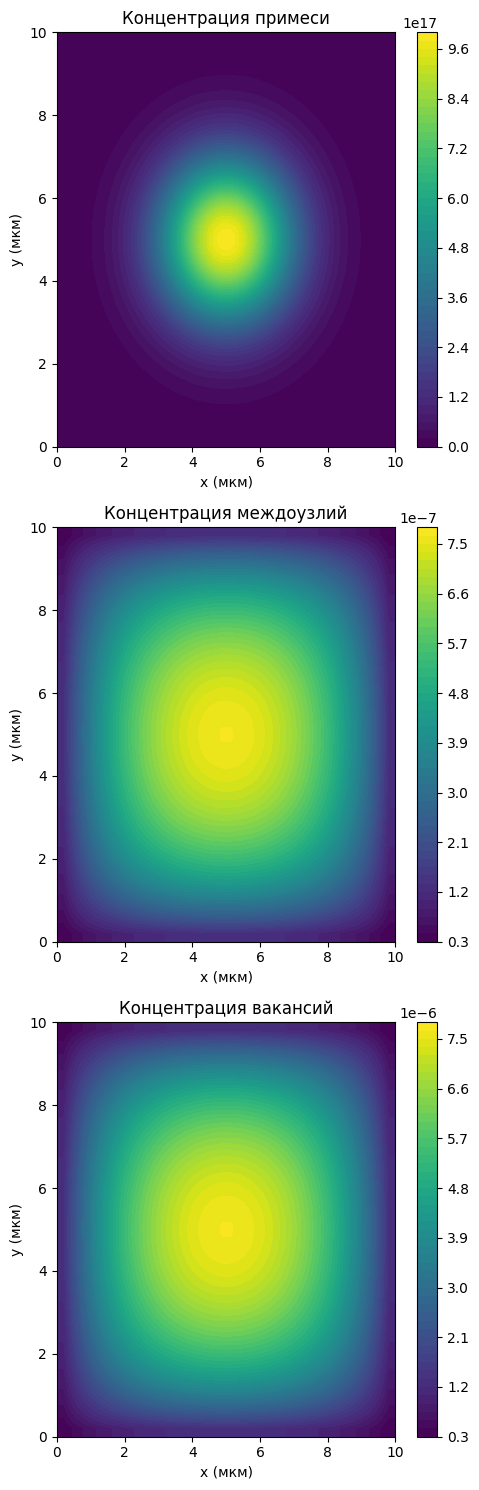

Симуляция завершена успешно!


In [6]:

# Пример использования симулятора
def example_simulation():
    # Параметры сетки
    nx, ny = 50, 50  # Уменьшим размер для скорости
    dx, dy = 2e-7, 2e-7  # 0.2 μm
    
    # Создание симулятора
    simulator = DiffusionSimulator2D(nx, ny, dx, dy)
    
    # Начальные условия - Gaussian профиль
    x = np.linspace(0, nx*dx, nx)
    y = np.linspace(0, ny*dy, ny)
    X, Y = np.meshgrid(x, y)
    
    # Центр распределения
    x0, y0 = nx*dx/2, ny*dy/2
    
    C_i0 = 1e18 * np.exp(-((X-x0)**2 + (Y-y0)**2) / (2e-6)**2)
    C_I0 = np.ones((ny, nx)) * 1e10  # равновесная концентрация
    C_V0 = np.ones((ny, nx)) * 1e10  # равновесная концентрация
    
    simulator.set_initial_conditions(C_i0, C_I0, C_V0)
    
    # Параметры материалов (более реалистичные значения)
    params = {
        'D_i_star': 1e-14,    # см²/с
        'f_I': 0.5,           # доля междоузельного механизма
        'D_I': 1e-6,          # диффузия междоузлий
        'D_V': 1e-7,          # диффузия вакансий  
        'K_R': 1e-21,         # константа рекомбинации
        'C_I_eq': 1e10,       # равновесная концентрация междоузлий
        'C_V_eq': 1e10,       # равновесная концентрация вакансий
        'T': 1100 + 273,      # температура в К
        'z': -1               # донорная примесь
    }
    
    # Временной цикл
    dt = 0.01
    n_steps = 50
    
    print("Запуск симуляции...")
    for step in range(n_steps):
        if step % 10 == 0:
            print(f"Шаг {step}/{n_steps}")
            
        # Вычисление коэффициента диффузии
        D_i = simulator.compute_diffusion_coefficient(
            params['D_i_star'], params['f_I'], 
            params['C_I_eq'], params['C_V_eq']
        )
        
        # Решение уравнений для точечных дефектов
        simulator.solve_defect_equations(
            dt, params['D_I'], params['D_V'], params['K_R'],
            params['C_I_eq'], params['C_V_eq']
        )
        
        # Решение уравнения для примеси
        simulator.solve_impurity_diffusion(
            dt, D_i, params['z'], params['T'], 1e-10
        )
        
        # Применение граничных условий
        simulator.apply_boundary_conditions()
    
    # Визуализация результатов
    plt.figure(figsize=(5, 15))
    
    plt.subplot(311)
    plt.contourf(X*1e6, Y*1e6, simulator.C_i, levels=50)
    plt.title('Концентрация примеси')
    plt.xlabel('x (мкм)')
    plt.ylabel('y (мкм)')
    plt.colorbar()
    
    plt.subplot(312)  
    plt.contourf(X*1e6, Y*1e6, simulator.C_I, levels=50)
    plt.title('Концентрация междоузлий')
    plt.xlabel('x (мкм)')
    plt.ylabel('y (мкм)')
    plt.colorbar()
    
    plt.subplot(313)
    plt.contourf(X*1e6, Y*1e6, simulator.C_V, levels=50)
    plt.title('Концентрация вакансий')
    plt.xlabel('x (мкм)')
    plt.ylabel('y (мкм)')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    print("Симуляция завершена успешно!")

# Запуск примера
if __name__ == "__main__":
    example_simulation()

=== Простая модель диффузии ===

1. Быстрый тест бора (маленькая сетка):
Симуляция B при 1273K
Параметры: Di=1.31e-05, D_dop=7.41e-16, f=0.9
Шагов: 1200, dt=0.05
  Шаг 0/1200
  Шаг 1000/1200
Симуляция завершена


Результаты:
Max Ci: 2.27e+13
Max dopant: 1.00e+18
Mean Ci/Ci_eq: 1.00


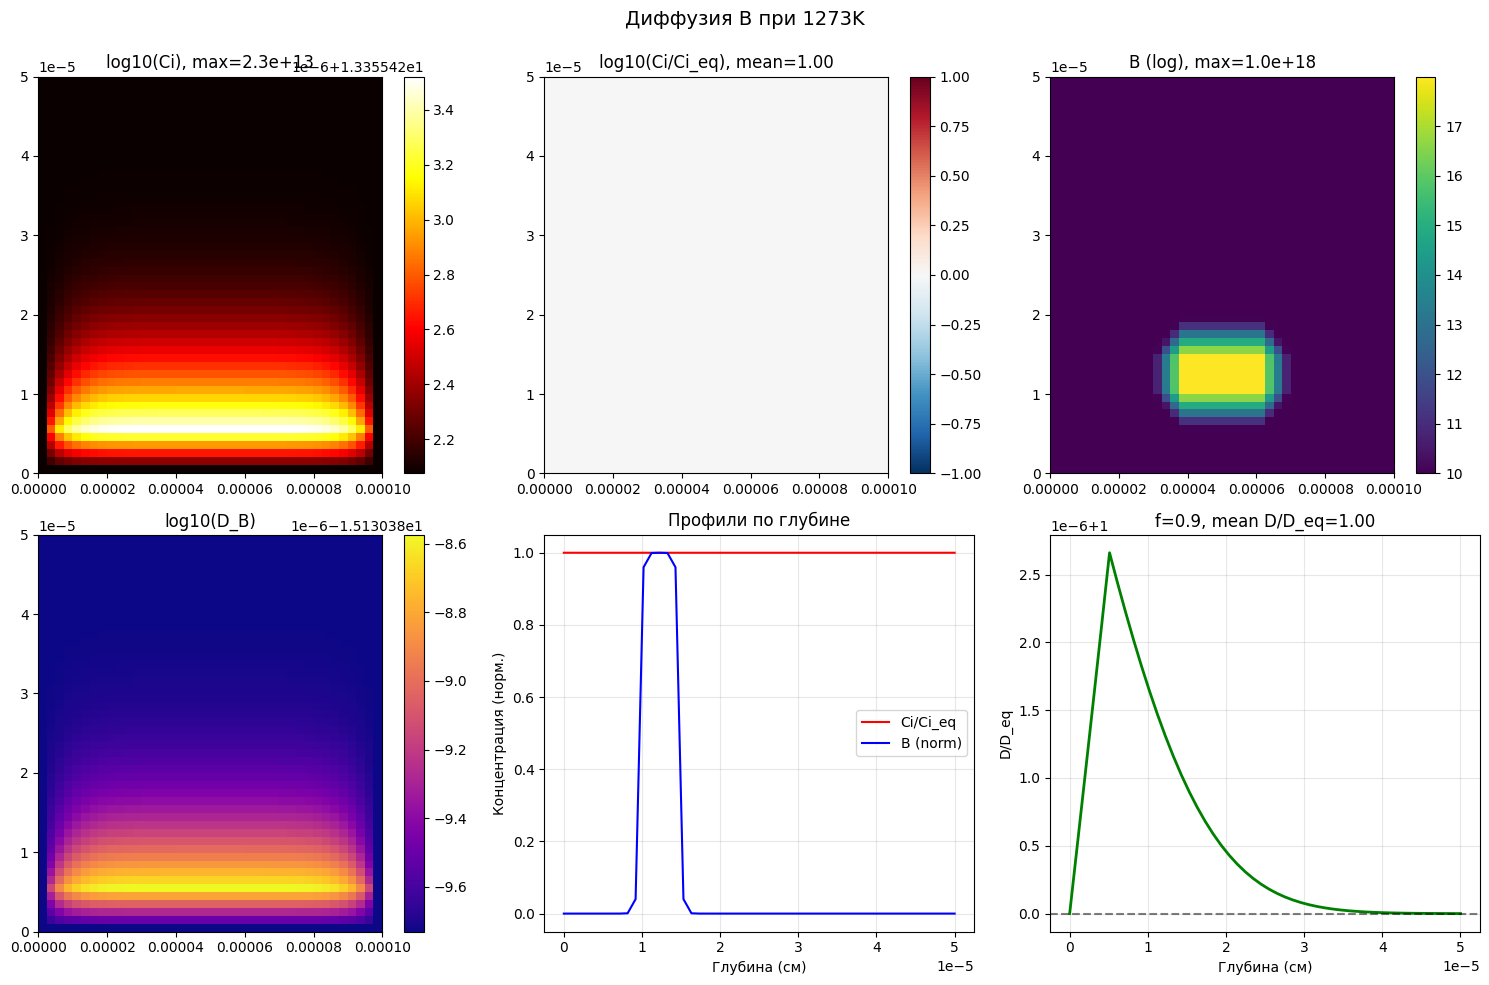

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class SimpleDiffusionModel:
    def __init__(self, nx=100, ny=100, Lx=2e-4, Ly=1e-4, T=1273):
        """
        Упрощенная модель диффузии с точечными дефектами
        nx, ny - размер сетки
        Lx, Ly - размер области (см)
        T - температура (K)
        """
        # Сетка (уменьшаем размер для стабильности)
        self.nx, self.ny = nx, ny
        self.x = np.linspace(0, Lx, nx)
        self.y = np.linspace(0, Ly, ny)
        self.dx, self.dy = self.x[1]-self.x[0], self.y[1]-self.y[0]
        
        # Температура
        self.T = T
        self.kT = 8.617e-5 * T  # эВ
        
        # Параметры из статьи
        self.set_parameters()
        
        # Концентрации (начальные условия)
        self.Ci = np.ones((ny, nx)) * self.Ci_eq
        self.dopant = np.zeros((ny, nx))
        
        # Маска оксида
        self.oxide_mask = np.ones((ny, nx))
        self.oxide_mask[:int(ny*0.1), :] = 0  # верхний слой - оксид
        
        # Параметры примеси
        self.dopant_type = 'B'
        self.set_dopant_params()
        
    def set_parameters(self):
        """Параметры из таблицы 1"""
        # Коэффициенты диффузии (см²/с)
        self.Di0 = 600e2
        self.E_Di = 2.44
        self.Di = max(self.Di0 * np.exp(-self.E_Di / self.kT), 1e-20)
        
        # Равновесные концентрации (см⁻³)
        self.Ci0 = 5.0e22
        self.E_Ci = 2.36
        self.Ci_eq = max(self.Ci0 * np.exp(-self.E_Ci / self.kT), 1e10)
        
        self.Cv0 = 2.0e-23
        self.E_Cv = 2.00
        self.Cv_eq = max(self.Cv0 * np.exp(-self.E_Cv / self.kT), 1e10)
        
        # Константа рекомбинации (см³/с)
        self.KR0 = 7.22e-19
        self.E_KR = 0.96
        self.KR = min(self.KR0 * np.exp(-self.E_KR / self.kT), 1e-10)
        
    def set_dopant_params(self, dopant='B'):
        """Параметры для разных примесей"""
        self.dopant_type = dopant
        
        params = {
            'B':  {'D0': 0.037, 'Ea': 3.46, 'f': 0.9},
            'P':  {'D0': 3.85,  'Ea': 3.66, 'f': 0.6},
            'As': {'D0': 0.066, 'Ea': 3.44, 'f': 0.3},
            'Sb': {'D0': 0.214, 'Ea': 3.65, 'f': 0.1}
        }
        
        p = params[dopant]
        self.D_dop0 = p['D0']
        self.Ea_dop = p['Ea']
        self.f = p['f']
        
        # Собственный коэф. диффузии
        self.D_dop_eq = max(self.D_dop0 * np.exp(-self.Ea_dop / self.kT), 1e-20)
    
    def oxidation_generation(self):
        """Генерация междоузлий при окислении (упрощенно)"""
        Vm = 5e22
        theta = 0.55
        v_ox = 1e-8  # постоянная скорость
        
        gi = np.zeros_like(self.Ci)
        
        # Находим границу Si/SiO2
        for i in range(1, self.ny-1):
            for j in range(1, self.nx-1):
                if self.oxide_mask[i,j] == 1:
                    if (self.oxide_mask[i-1,j] == 0 or self.oxide_mask[i+1,j] == 0 or
                        self.oxide_mask[i,j-1] == 0 or self.oxide_mask[i,j+1] == 0):
                        gi[i,j] = Vm * theta * v_ox
        
        return gi
    
    def update_Ci(self, dt):
        """Обновление концентрации междоузлий"""
        gi = self.oxidation_generation()
        
        # Уравнение: ∂Ci/∂t = Di∇²Ci - KR*Cv_eq*(Ci - Ci_eq) + gi
        # Простая явная схема
        
        # Диффузионный член
        diffusion = np.zeros_like(self.Ci)
        for i in range(1, self.ny-1):
            for j in range(1, self.nx-1):
                diffusion[i,j] = self.Di * (
                    (self.Ci[i+1,j] - 2*self.Ci[i,j] + self.Ci[i-1,j]) / self.dy**2 +
                    (self.Ci[i,j+1] - 2*self.Ci[i,j] + self.Ci[i,j-1]) / self.dx**2
                )
        
        # Рекомбинационный член
        recombination = self.KR * self.Cv_eq * (self.Ci - self.Ci_eq)
        
        dCi_dt = diffusion - recombination + gi
        
        # Ограничение шага по времени для стабильности
        max_dt = 0.25 * min(self.dx**2, self.dy**2) / (4 * self.Di + 1e-30)
        dt_safe = min(dt, max_dt)
        
        self.Ci += dt_safe * dCi_dt
        
        # Ограничиваем значения
        self.Ci = np.clip(self.Ci, 1e10, 1e30)
        self.Ci = np.nan_to_num(self.Ci, nan=self.Ci_eq)
    
    def get_D_dopant(self):
        """Коэффициент диффузии примеси с квазиравновесием"""
        # Ci/Ci_eq
        Ci_ratio = self.Ci / self.Ci_eq
        Ci_ratio = np.clip(Ci_ratio, 1e-10, 1e10)
        
        # Cv/Cv_eq = 1/(Ci/Ci_eq) из квазиравновесия
        Cv_ratio = 1.0 / Ci_ratio
        
        # D = D_eq * [f*(Ci/Ci_eq) + (1-f)*(Cv/Cv_eq)]
        D = self.D_dop_eq * (self.f * Ci_ratio + (1 - self.f) * Cv_ratio)
        
        return np.clip(D, 1e-20, 1e-5)
    
    def update_dopant_simple(self, dt):
        """Простое обновление концентрации примеси"""
        D = self.get_D_dopant()
        
        # Новая концентрация
        C_new = self.dopant.copy()
        
        for i in range(1, self.ny-1):
            for j in range(1, self.nx-1):
                # Потоки
                flux_right = D[i,j] * (self.dopant[i,j+1] - self.dopant[i,j]) / self.dx
                flux_left = D[i,j] * (self.dopant[i,j] - self.dopant[i,j-1]) / self.dx
                flux_up = D[i,j] * (self.dopant[i+1,j] - self.dopant[i,j]) / self.dy
                flux_down = D[i,j] * (self.dopant[i,j] - self.dopant[i-1,j]) / self.dy
                
                # Дивергенция
                div_flux = (flux_right - flux_left) / self.dx + (flux_up - flux_down) / self.dy
                
                C_new[i,j] = self.dopant[i,j] + dt * div_flux
        
        # Граничные условия: нулевой поток
        C_new[0,:] = self.dopant[0,:]
        C_new[-1,:] = self.dopant[-1,:]
        C_new[:,0] = self.dopant[:,0]
        C_new[:,-1] = self.dopant[:,-1]
        
        self.dopant = np.clip(C_new, 0, 1e30)
        self.dopant = np.nan_to_num(self.dopant, nan=0.0)
    
    def simulate(self, total_time, dt=0.01):
        """Основной цикл симуляции"""
        n_steps = int(total_time / dt)
        
        print(f"Симуляция {self.dopant_type} при {self.T}K")
        print(f"Параметры: Di={self.Di:.2e}, D_dop={self.D_dop_eq:.2e}, f={self.f}")
        print(f"Шагов: {n_steps}, dt={dt}")
        
        for step in range(n_steps):
            self.update_Ci(dt)
            self.update_dopant_simple(dt)
            
            if step % 1000 == 0:
                print(f"  Шаг {step}/{n_steps}")
        
        print("Симуляция завершена\n")
    
    def plot_results(self):
        """Визуализация результатов"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # 1. Междоузлия
        im1 = axes[0,0].imshow(np.log10(self.Ci), cmap='hot', 
                               extent=[0, self.x[-1], 0, self.y[-1]], 
                               origin='lower', aspect='auto')
        axes[0,0].set_title(f'log10(Ci), max={self.Ci.max():.1e}')
        plt.colorbar(im1, ax=axes[0,0])
        
        # 2. Отношение Ci/Ci_eq
        ci_ratio = self.Ci / self.Ci_eq
        im2 = axes[0,1].imshow(np.log10(ci_ratio), cmap='RdBu_r',
                               extent=[0, self.x[-1], 0, self.y[-1]],
                               origin='lower', aspect='auto',
                               vmin=-1, vmax=1)
        axes[0,1].set_title(f'log10(Ci/Ci_eq), mean={ci_ratio.mean():.2f}')
        plt.colorbar(im2, ax=axes[0,1])
        
        # 3. Примеси
        dopant_log = np.log10(self.dopant + 1e10)
        im3 = axes[0,2].imshow(dopant_log, cmap='viridis',
                               extent=[0, self.x[-1], 0, self.y[-1]],
                               origin='lower', aspect='auto')
        axes[0,2].set_title(f'{self.dopant_type} (log), max={self.dopant.max():.1e}')
        plt.colorbar(im3, ax=axes[0,2])
        
        # 4. Коэффициент диффузии
        D_eff = self.get_D_dopant()
        im4 = axes[1,0].imshow(np.log10(D_eff), cmap='plasma',
                               extent=[0, self.x[-1], 0, self.y[-1]],
                               origin='lower', aspect='auto')
        axes[1,0].set_title(f'log10(D_{self.dopant_type})')
        plt.colorbar(im4, ax=axes[1,0])
        
        # 5. Профили по глубине
        center_x = self.nx // 2
        depth = self.y
        
        axes[1,1].plot(depth, ci_ratio[:, center_x], 'r-', label='Ci/Ci_eq')
        axes[1,1].plot(depth, self.dopant[:, center_x] / max(self.dopant[:, center_x].max(), 1e-10), 
                       'b-', label=f'{self.dopant_type} (norm)')
        axes[1,1].set_xlabel('Глубина (см)')
        axes[1,1].set_ylabel('Концентрация (норм.)')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].set_title('Профили по глубине')
        
        # 6. Соотношение D/D_eq
        D_ratio = D_eff / self.D_dop_eq
        axes[1,2].plot(depth, D_ratio[:, center_x], 'g-', linewidth=2)
        axes[1,2].axhline(y=1, color='k', linestyle='--', alpha=0.5)
        axes[1,2].set_xlabel('Глубина (см)')
        axes[1,2].set_ylabel('D/D_eq')
        axes[1,2].set_title(f'f={self.f}, mean D/D_eq={D_ratio.mean():.2f}')
        axes[1,2].grid(True, alpha=0.3)
        
        plt.suptitle(f'Диффузия {self.dopant_type} при {self.T}K', fontsize=14)
        plt.tight_layout()
        plt.show()


# Быстрая демонстрация
if __name__ == "__main__":
    print("=== Простая модель диффузии ===\n")
    
    # Быстрый тест
    print("1. Быстрый тест бора (маленькая сетка):")
    model = SimpleDiffusionModel(nx=40, ny=50, Lx=1e-4, Ly=5e-5, T=1273)
    model.dopant[10:15, 15:25] = 1e18
    model.simulate(total_time=60, dt=0.05)  # 1 минута
    
    # Посмотрим результаты
    print("\nРезультаты:")
    print(f"Max Ci: {model.Ci.max():.2e}")
    print(f"Max dopant: {model.dopant.max():.2e}")
    print(f"Mean Ci/Ci_eq: {(model.Ci/model.Ci_eq).mean():.2f}")
    
    model.plot_results()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ImprovedDiffusionModel:
    def __init__(self, nx=100, ny=100, Lx=2e-4, Ly=1e-4, T=1273):
        """
        Улучшенная модель диффузии с точечными дефектами
        """
        # Сетка
        self.nx, self.ny = nx, ny
        self.x = np.linspace(0, Lx, nx)
        self.y = np.linspace(0, Ly, ny)
        self.dx, self.dy = self.x[1]-self.x[0], self.y[1]-self.y[0]
        
        # Температура
        self.T = T
        self.kT = 8.617e-5 * T  # эВ
        
        # Параметры из статьи
        self.set_parameters()
        
        # Концентрации (начальные условия)
        self.Ci = np.ones((ny, nx)) * self.Ci_eq
        self.Cv = np.ones((ny, nx)) * self.Cv_eq  # Добавляем вакансии
        self.dopant = np.zeros((ny, nx))
        
        # Маска (для края структуры)
        self.mask = np.ones((ny, nx))
        mask_start = int(nx * 0.4)
        mask_end = int(nx * 0.6)
        self.mask[:, mask_start:mask_end] = 0  # Центральная часть - маска
        
        # Генерация междоузлий на границе
        self.g_i = np.zeros((ny, nx))
        
        # Параметры примеси
        self.dopant_type = 'B'
        self.set_dopant_params()
        
        # Флаги условий
        self.use_quasi_equilibrium = True  # По умолчанию квазиравновесие
        
    def set_parameters(self, param_set='Bronner'):
        """Параметры из таблицы 1 статьи"""
        if param_set == 'Bronner':
            # Параметры из Bronner and Plummer (1987)
            self.Di0 = 600e2  # см²/с
            self.E_Di = 2.44  # эВ
            self.Ci0 = 5.0e22  # см⁻³
            self.E_Ci = 2.36  # эВ
            
            self.Dv0 = 0.10  # см²/с
            self.E_Dv = 2.00  # эВ
            self.Cv0 = 2.0e-23  # см⁻³
            self.E_Cv = 2.00  # эВ
            
            self.KR0 = 7.22e-19  # см³/с
            self.E_KR = 0.96  # эВ
            
        elif param_set == 'Boit':
            # Параметры из Boit et al (1990)
            self.Di0 = 1.03e2  # см²/с
            self.E_Di = 3.22  # эВ
            self.Ci0 = 3.11e19  # см⁻³
            self.E_Ci = 1.58  # эВ
            
            self.Dv0 = 6.34e3  # см²/с
            self.E_Dv = 3.29  # эВ
            self.Cv0 = 4.77e18  # см⁻³
            self.E_Cv = 0.713  # эВ
            
            self.KR0 = 1.40  # см³/с
            self.E_KR = 3.99  # эВ
        
        # Вычисление температурно-зависимых параметров
        self.Di = self.Di0 * np.exp(-self.E_Di / self.kT)
        self.Ci_eq = self.Ci0 * np.exp(-self.E_Ci / self.kT)
        self.Dv = self.Dv0 * np.exp(-self.E_Dv / self.kT)
        self.Cv_eq = self.Cv0 * np.exp(-self.E_Cv / self.kT)
        self.KR = self.KR0 * np.exp(-self.E_KR / self.kT)
        
        # Дополнительные параметры
        self.KI_min = 2.89e-2 * np.exp(-0.834 / self.kT)  # см/с
        self.KI_max = 1.29e5 * np.exp(-1.77 / self.kT)    # см/с
        self.KV_min = 1.37e3 * np.exp(-2.19 / self.kT)    # см/с
        self.KV_max = 1.91e9 * np.exp(-3.40 / self.kT)    # см/с
        
    def set_dopant_params(self, dopant='B'):
        """Параметры для разных примесей"""
        self.dopant_type = dopant
        
        # Параметры из статьи: f - доля междоузельного механизма
        params = {
            'B':  {'D0': 0.037, 'Ea': 3.46, 'f': 0.9, 'z': 1},    # акцептор
            'P':  {'D0': 3.85,  'Ea': 3.66, 'f': 0.6, 'z': -1},   # донор
            'As': {'D0': 0.066, 'Ea': 3.44, 'f': 0.3, 'z': -1},   # донор
            'Sb': {'D0': 0.214, 'Ea': 3.65, 'f': 0.1, 'z': -1}    # донор
        }
        
        p = params[dopant]
        self.D_dop0 = p['D0']
        self.Ea_dop = p['Ea']
        self.f = p['f']
        self.z = p['z']  # Заряд примеси
        
        # Собственный коэф. диффузии
        self.D_dop_eq = self.D_dop0 * np.exp(-self.Ea_dop / self.kT)
        
        # Электрическое поле (упрощенно)
        self.electric_field = np.zeros((self.ny, self.nx))
    
    def set_oxidation_conditions(self, oxidation_rate=1e-7, active_region=None):
        """
        Установка условий окисления
        
        Parameters:
        -----------
        oxidation_rate : float
            Скорость окисления (см/с)
        active_region : tuple or None
            (x_start, x_end) - область окисления в долях от Lx
        """
        self.oxidation_rate = oxidation_rate
        
        # Область окисления (по умолчанию вся поверхность)
        if active_region is None:
            active_region = (0.0, 1.0)
        
        self.oxidation_mask = np.zeros((self.ny, self.nx))
        x_start = int(active_region[0] * self.nx)
        x_end = int(active_region[1] * self.nx)
        self.oxidation_mask[0, x_start:x_end] = 1  # Верхняя граница
        
        # Параметры генерации междоузлий при окислении
        self.Vm = 5e22  # см⁻³
        self.theta = 0.55  # из таблицы 1
        
        # Генерация на границе окисления
        self.g_i = np.zeros((self.ny, self.nx))
        self.g_i[0, x_start:x_end] = self.Vm * self.theta * self.oxidation_rate
    
    def apply_quasi_equilibrium(self):
        """Применение условия квазиравновесия C_i * C_v = C_i_eq * C_v_eq"""
        if self.use_quasi_equilibrium:
            # C_v = C_i_eq * C_v_eq / C_i
            self.Cv = (self.Ci_eq * self.Cv_eq) / np.clip(self.Ci, 1e-10, None)
            self.Cv = np.clip(self.Cv, 1e10, 1e25)
    
    def apply_vacancy_equilibrium(self):
        """Применение условия равновесия вакансий C_v = C_v_eq"""
        self.Cv = np.ones_like(self.Cv) * self.Cv_eq
    
    def update_Ci_Cv(self, dt, use_implicit=True):
        """
        Обновление концентраций точечных дефектов
        
        Equations from paper:
        ∂C_i/∂t = ∇·(D_i∇C_i) - K_R(C_iC_v - C_i_eqC_v_eq) + g_i
        ∂C_v/∂t = ∇·(D_v∇C_v) - K_R(C_iC_v - C_i_eqC_v_eq)
        """
        # Создаем копии для обновления
        Ci_new = self.Ci.copy()
        Cv_new = self.Cv.copy()
        
        # Явная схема (простая, но требует малого шага)
        if not use_implicit:
            for i in range(1, self.ny-1):
                for j in range(1, self.nx-1):
                    # Диффузионный член для междоузлий
                    diff_i = self.Di * (
                        (self.Ci[i+1, j] - 2*self.Ci[i, j] + self.Ci[i-1, j]) / self.dy**2 +
                        (self.Ci[i, j+1] - 2*self.Ci[i, j] + self.Ci[i, j-1]) / self.dx**2
                    )
                    
                    # Диффузионный член для вакансий
                    diff_v = self.Dv * (
                        (self.Cv[i+1, j] - 2*self.Cv[i, j] + self.Cv[i-1, j]) / self.dy**2 +
                        (self.Cv[i, j+1] - 2*self.Cv[i, j] + self.Cv[i, j-1]) / self.dx**2
                    )
                    
                    # Рекомбинационный член
                    recombination = self.KR * (self.Ci[i, j] * self.Cv[i, j] - self.Ci_eq * self.Cv_eq)
                    
                    # Обновление
                    Ci_new[i, j] = self.Ci[i, j] + dt * (diff_i - recombination + self.g_i[i, j])
                    Cv_new[i, j] = self.Cv[i, j] + dt * (diff_v - recombination)
        
        # Применяем граничные условия
        # На поверхности: потоки определены K_I и K_V
        Ci_new[0, :] = self.Ci[0, :] + dt * (
            -self.KI_max * (self.Ci[0, :] - self.Ci_eq) + self.g_i[0, :]
        )
        Cv_new[0, :] = self.Cv[0, :] + dt * (
            -self.KV_max * (self.Cv[0, :] - self.Cv_eq)
        )
        
        # На других границах: нулевой поток (симметрия)
        Ci_new[-1, :] = Ci_new[-2, :]
        Ci_new[:, 0] = Ci_new[:, 1]
        Ci_new[:, -1] = Ci_new[:, -2]
        
        Cv_new[-1, :] = Cv_new[-2, :]
        Cv_new[:, 0] = Cv_new[:, 1]
        Cv_new[:, -1] = Cv_new[:, -2]
        
        # Обновляем массивы с ограничением
        self.Ci = np.clip(Ci_new, 1e10, 1e25)
        self.Cv = np.clip(Cv_new, 1e10, 1e25)
        
        # Применяем условия равновесия (если нужно)
        if self.use_quasi_equilibrium:
            self.apply_quasi_equilibrium()
        else:
            self.apply_vacancy_equilibrium()
    
    def get_effective_diffusivity(self):
        """
        Эффективный коэффициент диффузии с учетом точечных дефектов
        
        Equation (12) from paper:
        D_i = D_i^* [f * (C_i/C_i_eq) + (1-f) * (C_v/C_v_eq)]
        """
        # Отношения концентраций
        Ci_ratio = self.Ci / self.Ci_eq
        Cv_ratio = self.Cv / self.Cv_eq
        
        # Эффективный коэффициент диффузии
        D_eff = self.D_dop_eq * (self.f * Ci_ratio + (1 - self.f) * Cv_ratio)
        
        # Ограничиваем разумными значениями
        D_eff = np.clip(D_eff, 1e-20, 1e-5)
        
        return D_eff
    
    def update_dopant(self, dt):
        """
        Обновление концентрации примеси
        
        Equation (9) from paper:
        ∂C/∂t = ∇·[D∇C + (zq/kT) D C_act E]
        """
        D_eff = self.get_effective_diffusivity()
        
        # Простая модель без электрического поля
        C_new = self.dopant.copy()
        
        for i in range(1, self.ny-1):
            for j in range(1, self.nx-1):
                # Диффузионный член
                # Учитываем неоднородность D
                flux_x = 0.5 * (D_eff[i, j] + D_eff[i, j+1]) * (self.dopant[i, j+1] - self.dopant[i, j]) / self.dx
                flux_x -= 0.5 * (D_eff[i, j] + D_eff[i, j-1]) * (self.dopant[i, j] - self.dopant[i, j-1]) / self.dx
                
                flux_y = 0.5 * (D_eff[i, j] + D_eff[i+1, j]) * (self.dopant[i+1, j] - self.dopant[i, j]) / self.dy
                flux_y -= 0.5 * (D_eff[i, j] + D_eff[i-1, j]) * (self.dopant[i, j] - self.dopant[i-1, j]) / self.dy
                
                div_flux = flux_x / self.dx + flux_y / self.dy
                
                C_new[i, j] = self.dopant[i, j] + dt * div_flux
        
        # Граничные условия: нулевой поток
        C_new[0, :] = self.dopant[0, :]
        C_new[-1, :] = self.dopant[-1, :]
        C_new[:, 0] = self.dopant[:, 0]
        C_new[:, -1] = self.dopant[:, -1]
        
        # Под маской - нулевой поток (краевой эффект)
        mask_indices = np.where(self.mask == 0)
        C_new[mask_indices] = self.dopant[mask_indices]
        
        self.dopant = np.clip(C_new, 0, 1e30)
    
    def simulate(self, total_time, dt=None, output_interval=100):
        """
        Основной цикл симуляции с адаптивным шагом
        """
        if dt is None:
            # Автоматический выбор шага для стабильности
            dt = 0.1 * min(self.dx**2, self.dy**2) / (4 * max(self.Di, self.Dv, self.D_dop_eq))
        
        n_steps = int(total_time / dt)
        
        print(f"Симуляция {self.dopant_type} при {self.T}K ({self.T-273}°C)")
        print(f"Параметры:")
        print(f"  D_i = {self.Di:.2e} см²/с, C_i_eq = {self.Ci_eq:.2e} см⁻³")
        print(f"  D_v = {self.Dv:.2e} см²/с, C_v_eq = {self.Cv_eq:.2e} см⁻³")
        print(f"  D_{self.dopant_type} = {self.D_dop_eq:.2e} см²/с, f = {self.f}")
        print(f"  Шагов: {n_steps}, dt = {dt:.2e} с")
        print(f"  Условие: {'Квазиравновесие' if self.use_quasi_equilibrium else 'Равновесие вакансий'}")
        
        # Массивы для истории
        self.time_history = []
        self.max_Ci_history = []
        self.max_dopant_history = []
        
        for step in range(n_steps):
            current_time = step * dt
            
            # Обновление точечных дефектов
            self.update_Ci_Cv(dt, use_implicit=False)
            
            # Обновление примеси
            self.update_dopant(dt)
            
            # Сохранение истории
            if step % output_interval == 0:
                self.time_history.append(current_time)
                self.max_Ci_history.append(self.Ci.max())
                self.max_dopant_history.append(self.dopant.max())
                
                if step % (10 * output_interval) == 0:
                    print(f"  Время: {current_time:.1f} с, "
                          f"max(Ci) = {self.Ci.max():.2e}, "
                          f"max(dopant) = {self.dopant.max():.2e}")
        
        print(f"\nСимуляция завершена:")
        print(f"  Общее время: {total_time} с")
        print(f"  Final max(Ci): {self.Ci.max():.2e} см⁻³")
        print(f"  Final max({self.dopant_type}): {self.dopant.max():.2e} см⁻³")
        print(f"  Среднее Ci/Ci_eq: {(self.Ci/self.Ci_eq).mean():.2f}")
    
    def analyze_OED_effect(self):
        """Анализ эффекта OED/ORD"""
        # Коэффициент диффузии с эффектом и без
        D_with_defects = self.get_effective_diffusivity()
        D_intrinsic = self.D_dop_eq
        
        # Среднее отношение
        enhancement_factor = D_with_defects.mean() / D_intrinsic
        
        print(f"\nАнализ OED/ORD для {self.dopant_type}:")
        print(f"  Коэффициент усиления диффузии: {enhancement_factor:.3f}")
        
        if enhancement_factor > 1.2:
            print(f"  Наблюдается OED (усиление диффузии)")
        elif enhancement_factor < 0.8:
            print(f"  Наблюдается ORD (замедление диффузии)")
        else:
            print(f"  Слабое влияние точечных дефектов")
        
        return enhancement_factor
    
    def plot_results(self, save_path=None):
        """Визуализация результатов"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # 1. Концентрация междоузлий
        im1 = axes[0,0].imshow(np.log10(self.Ci), cmap='hot', 
                               extent=[0, self.x[-1]*1e4, 0, self.y[-1]*1e4],
                               origin='lower', aspect='auto')
        axes[0,0].set_title(f'log10(C_i) [см⁻³]')
        axes[0,0].set_xlabel('x (мкм)')
        axes[0,0].set_ylabel('y (мкм)')
        plt.colorbar(im1, ax=axes[0,0])
        
        # 2. Отношение C_i/C_i_eq
        ci_ratio = self.Ci / self.Ci_eq
        im2 = axes[0,1].imshow(np.log10(ci_ratio), cmap='RdBu_r',
                               extent=[0, self.x[-1]*1e4, 0, self.y[-1]*1e4],
                               origin='lower', aspect='auto',
                               vmin=-2, vmax=2)
        axes[0,1].set_title(f'log10(C_i/C_i_eq)')
        axes[0,1].set_xlabel('x (мкм)')
        plt.colorbar(im2, ax=axes[0,1])
        
        # 3. Концентрация примеси
        dopant_to_plot = np.log10(self.dopant + 1e10)  # Добавляем малое значение для логарифма
        im3 = axes[0,2].imshow(dopant_to_plot, cmap='viridis',
                               extent=[0, self.x[-1]*1e4, 0, self.y[-1]*1e4],
                               origin='lower', aspect='auto')
        axes[0,2].set_title(f'{self.dopant_type} концентрация [log10 см⁻³]')
        axes[0,2].set_xlabel('x (мкм)')
        plt.colorbar(im3, ax=axes[0,2])
        
        # 4. Эффективный коэффициент диффузии
        D_eff = self.get_effective_diffusivity()
        im4 = axes[1,0].imshow(np.log10(D_eff), cmap='plasma',
                               extent=[0, self.x[-1]*1e4, 0, self.y[-1]*1e4],
                               origin='lower', aspect='auto')
        axes[1,0].set_title(f'log10(D_eff) [см²/с]')
        axes[1,0].set_xlabel('x (мкм)')
        axes[1,0].set_ylabel('y (мкм)')
        plt.colorbar(im4, ax=axes[1,0])
        
        # 5. Профили по глубине
        center_x = self.nx // 2
        depth = self.y * 1e4  # в мкм
        
        axes[1,1].plot(depth, ci_ratio[:, center_x], 'r-', linewidth=2, label='C_i/C_i_eq')
        axes[1,1].plot(depth, self.dopant[:, center_x] / max(self.dopant[:, center_x].max(), 1e-10), 
                       'b-', linewidth=2, label=f'{self.dopant_type} (норм.)')
        axes[1,1].axvline(x=depth[int(self.ny*0.1)], color='k', linestyle='--', alpha=0.5, label='Маска')
        axes[1,1].set_xlabel('Глубина (мкм)')
        axes[1,1].set_ylabel('Относительная концентрация')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].set_title('Профили по глубине (центр)')
        
        # 6. История максимумов
        if hasattr(self, 'time_history') and len(self.time_history) > 0:
            ax_twin = axes[1,2].twinx()
            axes[1,2].plot(self.time_history, np.array(self.max_Ci_history)/self.Ci_eq, 
                          'r-', linewidth=2, label='max(C_i)/C_i_eq')
            ax_twin.plot(self.time_history, np.array(self.max_dopant_history)/max(self.max_dopant_history[-1], 1e10),
                        'b-', linewidth=2, label=f'max({self.dopant_type})')
            axes[1,2].set_xlabel('Время (с)')
            axes[1,2].set_ylabel('max(C_i)/C_i_eq', color='r')
            ax_twin.set_ylabel(f'Концентрация {self.dopant_type} (норм.)', color='b')
            axes[1,2].grid(True, alpha=0.3)
            axes[1,2].set_title('История максимумов')
            axes[1,2].legend(loc='upper left')
            ax_twin.legend(loc='upper right')
        
        plt.suptitle(f'Диффузия {self.dopant_type} при {self.T-273:.0f}°C\n'
                    f'f={self.f}, условие: {"квазиравновесие" if self.use_quasi_equilibrium else "равновесие вакансий"}', 
                    fontsize=14, y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()


# Демонстрация работы
if __name__ == "__main__":

    print("=== Улучшенная модель диффузии с точечными дефектами ===\n")
    
    print("1. Тест: Бор при окислении (OED эффект)")
    print("-" * 50)
    
    # Создаем модель
    model1 = ImprovedDiffusionModel(nx=60, ny=80, Lx=1e-4, Ly=6e-5, T=1273)
    model1.set_dopant_params('B')
    
    # Начальное распределение примеси
    model1.dopant[10:20, 20:40] = 1e18  # Поверхностный слой
    
    # Устанавливаем условия окисления (только левая часть)
    model1.set_oxidation_conditions(oxidation_rate=1e-7, active_region=(0.0, 0.5))
    
    # Используем квазиравновесие
    model1.use_quasi_equilibrium = True
    
    # Запускаем симуляцию
    model1.simulate(total_time=180, dt=0.1, output_interval=500)
    
    # Анализ эффекта OED
    enhancement = model1.analyze_OED_effect()
    
    # Визуализация
    model1.plot_results()
    

    print("\n" + "="*50)
    print("2. Тест: Сравнение B и Sb (OED vs ORD)")
    print("-" * 50)
    
    # Для бора (ожидаем OED)
    model_B = ImprovedDiffusionModel(nx=50, ny=60, Lx=8e-5, Ly=4e-5, T=1273)
    model_B.set_dopant_params('B')
    model_B.dopant[8:15, 15:35] = 1e18
    model_B.set_oxidation_conditions(oxidation_rate=5e-8)
    model_B.simulate(total_time=120, dt=0.2)
    enh_B = model_B.analyze_OED_effect()
    
    print("\n" + "-"*30)
    
    # Для сурьмы (ожидаем ORD)
    model_Sb = ImprovedDiffusionModel(nx=50, ny=60, Lx=8e-5, Ly=4e-5, T=1273)
    model_Sb.set_dopant_params('Sb')
    model_Sb.dopant[8:15, 15:35] = 1e18
    model_Sb.set_oxidation_conditions(oxidation_rate=5e-8)
    model_Sb.simulate(total_time=120, dt=0.2)
    enh_Sb = model_Sb.analyze_OED_effect()
    
    print("\n" + "="*50)
    print(f"Итоговое сравнение:")
    print(f"  Boron (f={model_B.f}): enhancement = {enh_B:.3f} {'(OED)' if enh_B > 1.2 else ''}")
    print(f"  Antimony (f={model_Sb.f}): enhancement = {enh_Sb:.3f} {'(ORD)' if enh_Sb < 0.8 else ''}")
    print(f"\nВывод: Бор (большой f) усиливается при окислении, сурьма (малый f) замедляется.")

